In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import yellowbrick.regressor as yr
from yellowbrick.classifier import ROCAUC

In [48]:
training_data = pd.read_csv("data/training_min_max_scaled.csv")
test_data = pd.read_csv("data/test_min_max_scaled.csv")

In [49]:
training_data.head()

,ID,Cycle,TTF,TTF_LABEL,S1,S2,S3,S4
0,1,1,191,0,0.309757,0.726248,0.369048,0.633262
1,1,2,190,0,0.352633,0.628019,0.380952,0.765458
2,1,3,189,0,0.370527,0.710145,0.250000,0.795309
3,1,4,188,0,0.331195,0.740741,0.166667,0.889126
4,1,5,187,0,0.404625,0.668277,0.255952,0.746269


In [50]:
test_data.head()

,ID,Cycle,TTF,TTF_LABEL,S1,S2,S3,S4
0,1,31,112,0,0.281229,0.735910,0.226190,0.660981
1,2,49,98,0,0.482444,0.590982,0.488095,0.650320
2,3,126,69,0,0.618501,0.441224,0.613095,0.456290
3,4,106,82,0,0.415766,0.449275,0.476190,0.680171
4,5,98,91,0,0.626435,0.553945,0.363095,0.492537


In [76]:
# Define features and target
features = ["S1", "S2", "S3", "S4", "Cycle"]
target = "TTF_LABEL"

In [77]:
X_train = training_data[features]
y_train = training_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [7]:
X_train.head()


,S1,S2,S3,S4
0,1400.60,554.36,47.47,521.66
1,1403.14,553.75,47.49,522.28
2,1404.20,554.26,47.27,522.42
3,1401.87,554.45,47.13,522.86
4,1406.22,554.00,47.28,522.19


In [8]:
y_train.head()


0    0
1    0
2    0
3    0
4    0
Name: TTF_LABEL, dtype: int64

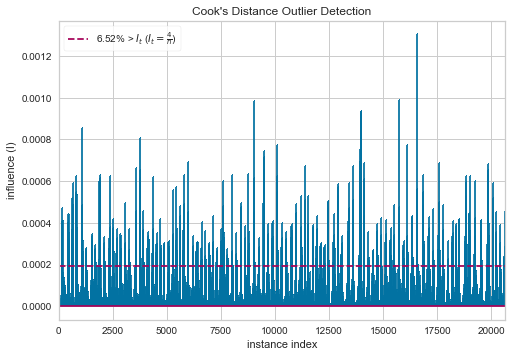

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [61]:
visualizer = yr.CooksDistance()
visualizer.fit(X_train, y_train)
visualizer.show()

In [62]:
i_less_influential = visualizer.distance_ <= visualizer.influence_threshold_
X_pruned, y_pruned = X_train[i_less_influential], y_train[i_less_influential]

## Helper Methods

### Hyperparameter Tuning

In [53]:
def tune_hyperparameters(
    classifier, parameters_grid, X_train, y_train, cv=5, score=None
):
    """Tune the hyperparameters of a regression model using Grid Search

    Args:
        regressor (str): The model name identifier
        parameters_grid (dict): The hyperparameters grid
        X_train (dataframe): The training features
    """
    grid = GridSearchCV(classifier, parameters_grid, cv=cv, scoring=score)
    grid.fit(X_train, y_train)
    print(
        f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}"
    )
    return grid.best_estimator_

### Generate prediction scores

In [54]:
def generate_scores(classifer, X_train, y_train):
    """Generate the scores of the model

    Args:
        classifer (str): The model name identifier
        X_train (dataframe): The training features
        y_train (dataframe): The training target
    """
    return classifer.predict_proba(X_train)[:, 1], classifer.predict_proba(X_test)[:, 1]

### Classification Metrics
Metrics to be considered:
- Accuracy
- Precision
- Recall
- F1
- ROC AUC

In [55]:
def calculate_classification_metrics(model_name, training_actual, training_predictions, training_scores, test_actual, test_predictions, test_scores):
    """Calculate the classification metrics

    Args:
        model_name (str): The model name identifier
        training_actual (dataframe): The training actual values
        training_predictions (dataframe): The training predicted values
        test_actual (dataframe): The test actual values
        test_predictions (dataframe): The test predicted values
    """
    training_metrics = {
        "Accuracy": accuracy_score(training_actual, training_predictions),
        "Precision": precision_score(training_actual, training_predictions),
        "Recall": recall_score(training_actual, training_predictions),
        "F1": f1_score(training_actual, training_predictions),
        "ROC AUC": roc_auc_score(training_actual, training_scores),
    }

    test_metrics = {
        "Accuracy": accuracy_score(test_actual, test_predictions),
        "Precision": precision_score(test_actual, test_predictions),
        "Recall": recall_score(test_actual, test_predictions),
        "F1": f1_score(test_actual, test_predictions),
        "ROC AUC": roc_auc_score(test_actual, test_scores),
    }

    metrics = {
        f"{model_name} (Training)": training_metrics,
        f"{model_name} (Test)": test_metrics
    }

    return pd.DataFrame.from_dict(metrics)


### Generate Classification Thresholds

In [ ]:
def generate_thresholds(y_test, y_scores):
    
    fpr, tpr, thresholds = precision_recall_curve(y_test, y_scores)
    rocs = [(y_scores >= threshold).mean() for threshold in thresholds]
    

### Plot Confusion Matrix

In [56]:
def plot_confusion_matrix(
    actual, predicted, cmap="Blues"):
    """Plot the confusion matrix

    Args:
        actual (array): The actual values
        predicted (array): The predicted values
        cmap (str): The color map
    """
    cm = confusion_matrix(actual, predicted)
    group_labels = ["True Positive", "False Positive", "False Negative", "True Negative"]
    counts = [
        "{0:0.0f}".format(value) for value in cm.flatten()
    ]
    percentages = [
        "{0:.2%}".format(value)
        for value in cm.flatten() / np.sum(cm)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_labels, counts, percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap=cmap)

### Plot ROC Curve

In [57]:
def plot_roc(model_name, classifier, actual, predicted):
    """Plot the ROC curve

    Args:
        model_name (str): The model name identifier
        classifier (str): The classifier 
        actual (array): The actual values
        predicted (array): The predicted values
    """
    fpr, tpr, threshold = roc_curve(actual, predicted)

## Logistic Regression

In [146]:
# Perform grid search on logistic regression
c_space = [.01, 0.1, 1.0, 10]
parameters_grid = { "C": c_space }
tuned_logistic_classifier = tune_hyperparameters(LogisticRegression(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'C': 1.0} with a score of 0.9798043468427091


In [180]:
# Fit the classifier and predict on test data
training_predictions = tuned_logistic_classifier.predict(X_train)
test_predictions = tuned_logistic_classifier.predict(X_test)

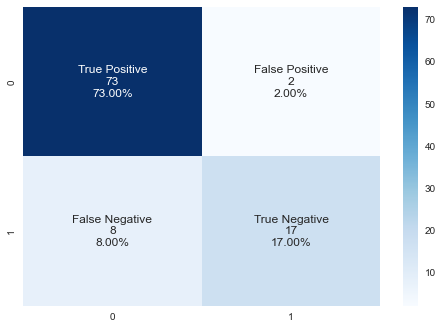

In [128]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

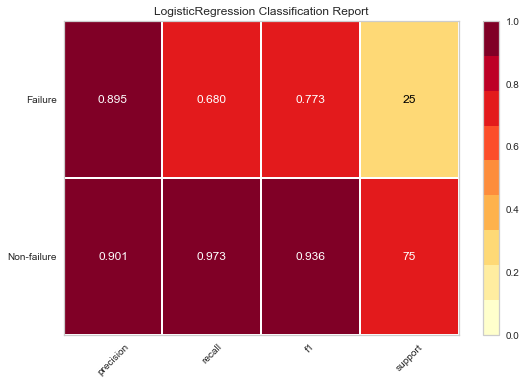

In [46]:
# Plot the confusion matrix
visualizer = yc_classification_report(
    LogisticRegression(), X_train, y_train, X_test, y_test, classes=["Non-failure", "Failure"], support=True
)

In [173]:
# Calculate the classification metrics
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_logistic_classifier, X_train, y_train)
logistic_regression_classification_metrics = calculate_classification_metrics('Logistic Regression', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
logistic_regression_classification_metrics

,Logistic Regression (Training),Logistic Regression (Test)
Accuracy,0.945858,0.900000
Precision,0.847529,0.894737
Recall,0.780000,0.680000
F1,0.812364,0.772727
ROC AUC,0.980041,0.959467


In [103]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):

    """Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.

    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves

    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold

    """

    binclass_metrics = {
        "Accuracy": metrics.accuracy_score(y_test, y_pred),
        "Precision": metrics.precision_score(y_test, y_pred),
        "Recall": metrics.recall_score(y_test, y_pred),
        "F1 Score": metrics.f1_score(y_test, y_pred),
        "ROC AUC": metrics.roc_auc_score(y_test, y_score),
    }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient="index")
    df_metrics.columns = [model]

    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)

    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []
    for thr in thresh_roc:
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {"Threshold": thresh_roc, "TPR": tpr, "FPR": fpr, "Que": engines_roc}

    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)

    # calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    # from ground truth file, positive class = 25 => TP + FN = 25
    # from ground truth file, negative class = 75 => TN + FP = 75

    df_roc_thresh["TP"] = (25 * df_roc_thresh.TPR).astype(int)
    df_roc_thresh["FP"] = (25 - (25 * df_roc_thresh.TPR)).astype(int)
    df_roc_thresh["TN"] = (75 * (1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh["FN"] = (75 - (75 * (1 - df_roc_thresh.FPR))).astype(int)

    df_roc_thresh["TNR"] = df_roc_thresh["TN"] / (
        df_roc_thresh["TN"] + df_roc_thresh["FN"]
    )
    df_roc_thresh["FNR"] = df_roc_thresh["TN"] / (
        df_roc_thresh["TN"] + df_roc_thresh["FP"]
    )

    df_roc_thresh["Model"] = model

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc, 1)

    engines_prc = []
    for thr in thresh_prc:
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
        "Threshold": thresh_prc,
        "Precision": precision,
        "Recall": recall,
        "Que": engines_prc,
    }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print("-----------------------------------------------------------")
        print(model, "\n")
        print("Confusion Matrix:")
        print(metrics.confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(metrics.classification_report(y_test, y_pred))
        print("\nMetrics:")
        print(df_metrics)

        print("\nROC Thresholds:\n")
        print(
            df_roc_thresh[
                ["Threshold", "TP", "FP", "TN", "FN", "TPR", "FPR", "TNR", "FNR", "Que"]
            ]
        )

        print("\nPrecision-Recall Thresholds:\n")
        print(df_prc_thresh[["Threshold", "Precision", "Recall", "Que"]])

    if plot_out:
        plt, ((ax1, plt), (ax3, ax4)) = plt.subplots(
            nrows=2, ncols=2, sharex=False, sharey=False
        )
        plt.set_size_inches(10, 10)

        ax1.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % roc_auc)
        ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.legend(loc="lower right", fontsize="small")

        plt.plot(recall, precision, color="blue", lw=2, label="Precision-Recall curve")
        plt.set_xlim([0.0, 1.0])
        plt.set_ylim([0.0, 1.05])
        plt.set_xlabel("Recall")
        plt.set_ylabel("Precision")
        plt.legend(loc="lower left", fontsize="small")

        ax3.plot(thresh_roc, fpr, color="red", lw=2, label="FPR")
        ax3.plot(thresh_roc, tpr, color="green", label="TPR")
        ax3.plot(thresh_roc, engines_roc, color="blue", label="Engines")
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel("Threshold")
        ax3.set_ylabel("%")
        ax3.legend(loc="upper right", fontsize="small")

        ax4.plot(thresh_prc, precision, color="red", lw=2, label="Precision")
        ax4.plot(thresh_prc, recall, color="green", label="Recall")
        ax4.plot(thresh_prc, engines_prc, color="blue", label="Engines")
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel("Threshold")
        ax4.set_ylabel("%")
        ax4.legend(loc="lower left", fontsize="small")

    return df_metrics, df_roc_thresh, df_prc_thresh


In [181]:
metrics_log, roc_lgrb, prc_lgrb = bin_class_metrics('Logistic Regression', y_test, test_predictions, prediction_probabilities_test, print_out=True, plot_out=False)

-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[73  2]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100


Metrics:
           Logistic Regression
Accuracy              0.900000
Precision             0.894737
Recall                0.680000
F1 Score              0.772727
ROC AUC               0.959467

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.989837   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    0.989837   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2    0.753645  13  12  75   0  0.52  0.000000  1.000000  0.862069  0.13
3    0.726748  13  12  74   

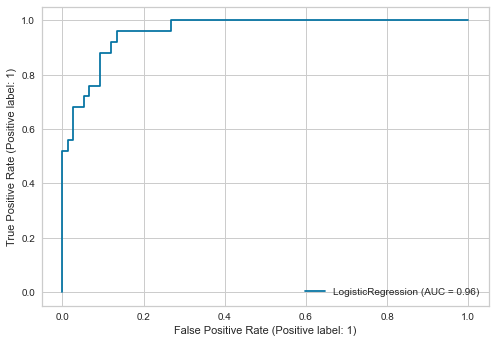

In [41]:
RocCurveDisplay.from_estimator(tuned_logistic_classifier, X_test, y_test)

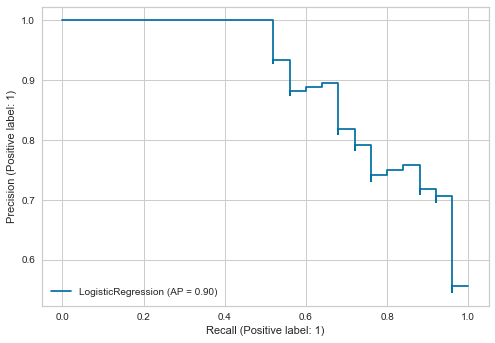

In [42]:
PrecisionRecallDisplay.from_estimator(tuned_logistic_classifier, X_test, y_test)

## Decision Tree classification

In [76]:
# Perform grid search on decision tree
max_depth_space = [2, 3, 4, 5, 6, 7, 8]
criterion_space = ["gini", "entropy"]
parameters_grid = { "max_depth": max_depth_space, "criterion": criterion_space }
tuned_decision_tree_classifier = tune_hyperparameters(DecisionTreeClassifier(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'criterion': 'entropy', 'max_depth': 4} with a score of 0.9735171572097878


In [80]:
# Make predictions on training and test data
training_predictions = tuned_decision_tree_classifier.predict(X_train)
test_predictions = tuned_decision_tree_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_decision_tree_classifier, X_train, y_train)

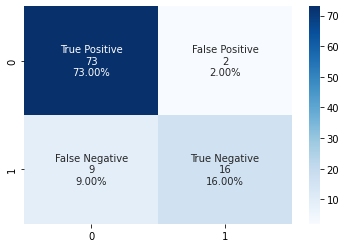

In [81]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [82]:
# Calculate the classification metrics
decision_tree_classification_metrics = calculate_classification_metrics('Decision Tree', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
decision_tree_classification_metrics

,Decision Tree (Training),Decision Tree (Test)
Accuracy,0.943677,0.890000
Precision,0.885748,0.888889
Recall,0.717742,0.640000
F1,0.792944,0.744186
ROC AUC,0.976331,0.945333


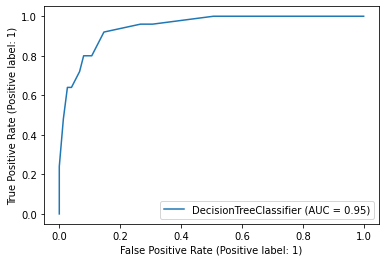

In [93]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_decision_tree_classifier, X_test, y_test)

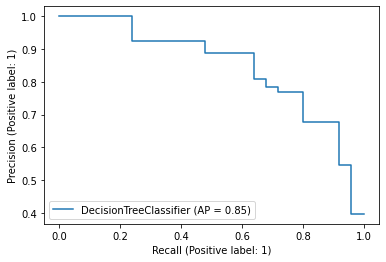

In [94]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_decision_tree_classifier, X_test, y_test)

## Random Forest classification

In [150]:
# Perform grid search on random forest
max_depth_space = [2, 3, 4, 5, 6, 7, 8]
criterion_space = ["gini", "entropy"]
parameters_grid = { "max_depth": max_depth_space, "criterion": criterion_space }

tuned_random_forest_classifier = tune_hyperparameters(RandomForestClassifier(random_state=42), parameters_grid, X_train, y_train, score='roc_auc')


The best parameters are {'criterion': 'entropy', 'max_depth': 6} with a score of 0.9816678104591393


In [182]:
# Make predictions on training and test data
training_predictions = tuned_random_forest_classifier.predict(X_train)
test_predictions = tuned_random_forest_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_random_forest_classifier, X_train, y_train)

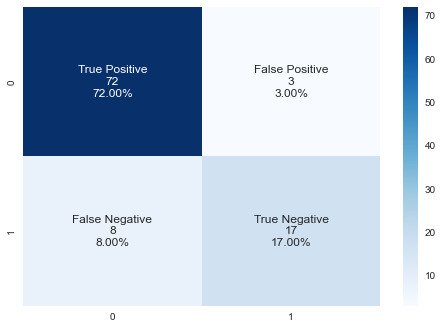

In [109]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [153]:
# Calculate the classification metrics
random_forest_classification_metrics = calculate_classification_metrics('Random Forest', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
random_forest_classification_metrics

,Random Forest (Training),Random Forest (Test)
Accuracy,0.950705,0.890000
Precision,0.870509,0.850000
Recall,0.789355,0.680000
F1,0.827948,0.755556
ROC AUC,0.985398,0.963733


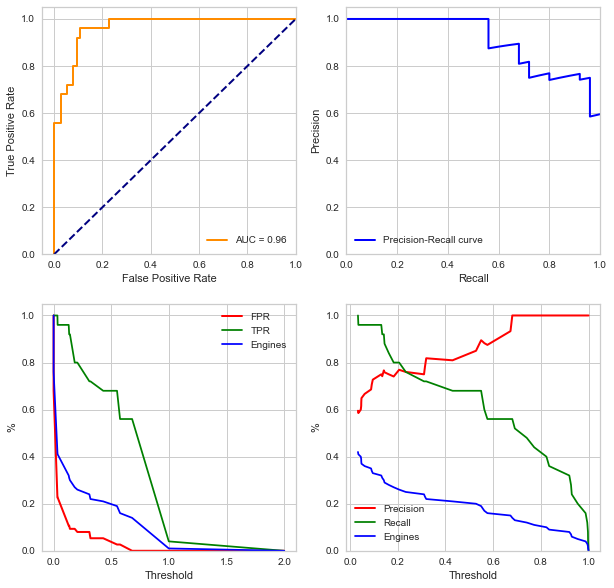

In [186]:
metrics_rf, roc_rf, prc_rf = bin_class_metrics('Random Forest', y_test, test_predictions, prediction_probabilities_test, print_out=False, plot_out=True)

In [184]:
prc_rf

,Threshold,Precision,Recall,Que
0,0.033059,0.595238,1.00,0.42
1,0.034751,0.585366,0.96,0.41
2,0.044872,0.600000,0.96,0.40
3,0.046579,0.615385,0.96,0.39
4,0.046884,0.631579,0.96,0.38
5,0.047732,0.648649,0.96,0.37
6,0.061046,0.666667,0.96,0.36
7,0.088023,0.685714,0.96,0.35
8,0.090751,0.705882,0.96,0.34
9,0.095232,0.727273,0.96,0.33


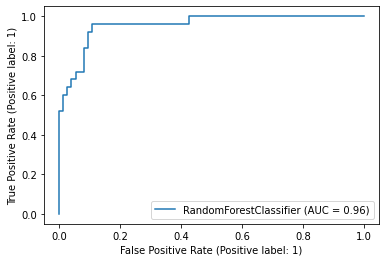

In [110]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_random_forest_classifier, X_test, y_test)

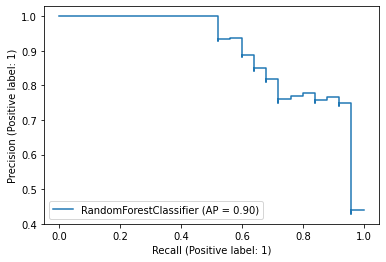

In [111]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_random_forest_classifier, X_test, y_test)

## K-Nearest Neighbors

In [116]:
# Perform grid search on KNN
n_neighbors_space = [6, 7, 8, 9, 10, 11, 12, 13, 14]
parameters_grid = { "n_neighbors": n_neighbors_space }
tuned_knn_classifier = tune_hyperparameters(KNeighborsClassifier(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'n_neighbors': 14} with a score of 0.9620683849374811


In [117]:
# Make predictions on training and test data
training_predictions = tuned_knn_classifier.predict(X_train)
test_predictions = tuned_knn_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_knn_classifier, X_train, y_train)

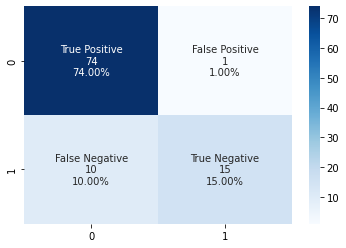

In [118]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [119]:
# Calculate the classification metrics
knn_classification_metrics = calculate_classification_metrics('KNN', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
knn_classification_metrics

,KNN (Training),KNN (Test)
Accuracy,0.946925,0.890000
Precision,0.868431,0.937500
Recall,0.762258,0.600000
F1,0.811888,0.731707
ROC AUC,0.982859,0.928267


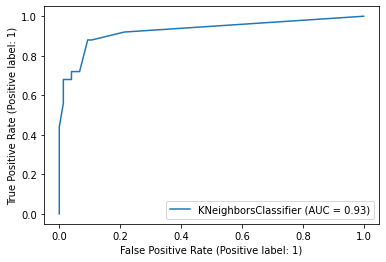

In [120]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_knn_classifier, X_test, y_test)

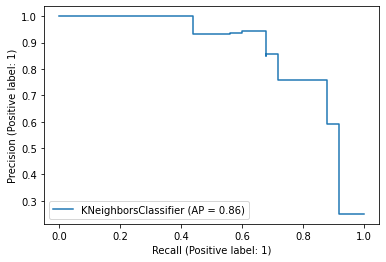

In [121]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_knn_classifier, X_test, y_test)

## Support Vector Machine classification

In [124]:
# Perform grid search on SVM
c_space = [.001, .01 ,.1 , 1, 10, 20, 100]
parameters_grid = { 'C' : c_space }
tuned_svm = tune_hyperparameters(SVC(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'C': 100} with a score of 0.9674415327955659


In [ ]:
# Make predictions on training and test data
training_predictions = tuned_svm.predict(X_train)
test_predictions = tuned_svm.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_svm, X_train, y_train)

In [125]:
# Calculate the classification metrics
svm_classification_metrics = calculate_classification_metrics('SVM', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
svm_classification_metrics

,SVM (Training),SVM (Test)
Accuracy,0.946925,0.890000
Precision,0.868431,0.937500
Recall,0.762258,0.600000
F1,0.811888,0.731707
ROC AUC,0.982859,0.928267


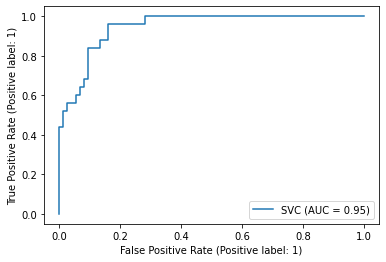

In [126]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_svm, X_test, y_test)

## Gaussian Naive Bayes

In [156]:
# Define the naive bayes model and fit it to the training data
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

GaussianNB()

In [157]:
# Make predictions on training and test data
training_predictions = naive_bayes_model.predict(X_train)
test_predictions = naive_bayes_model.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(naive_bayes_model, X_train, y_train)

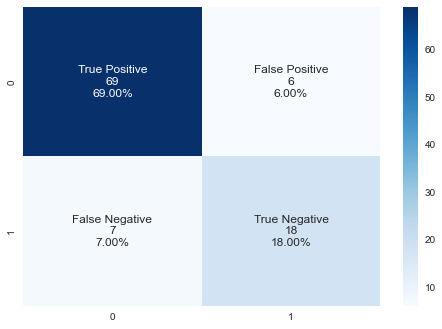

In [118]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [115]:
# Calculate the classification metrics
naive_bayes_classification_metrics = calculate_classification_metrics('Naive Bayes', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
naive_bayes_classification_metrics

,Naive Bayes (Training),Naive Bayes (Test)
Accuracy,0.926373,0.870000
Precision,0.691729,0.750000
Recall,0.920000,0.720000
F1,0.789700,0.734694
ROC AUC,0.980129,0.958933


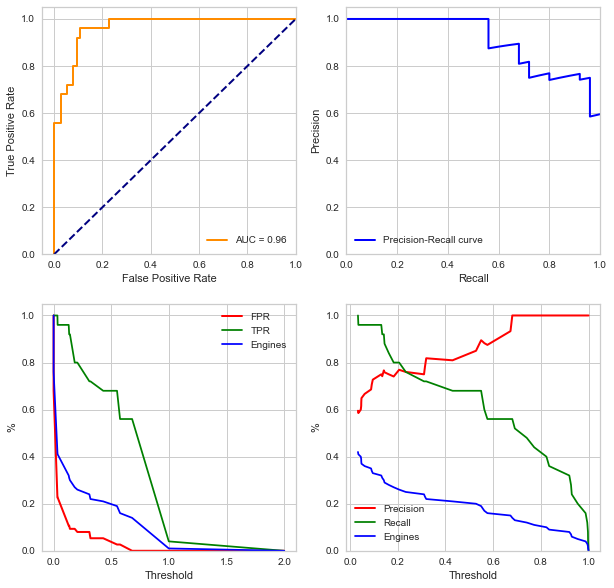

In [185]:
metrics_nb, roc_nb, prc_nb = bin_class_metrics('Naive Bayes', y_test, test_predictions, prediction_probabilities_test, print_out=False, plot_out=True)

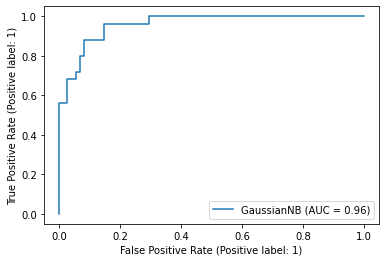

In [132]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(naive_bayes_model, X_test, y_test)

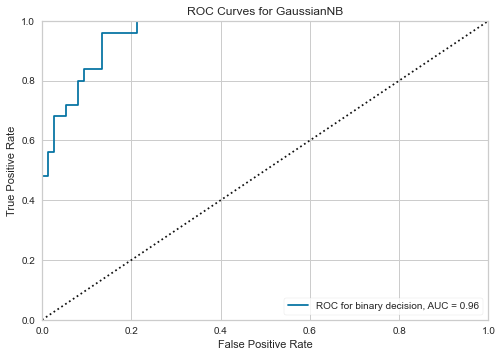

<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [122]:
visualizer = ROCAUC(GaussianNB(), classes=[0, 1], binary=True)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

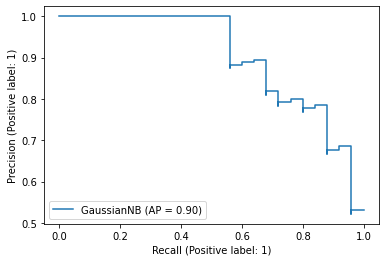

In [133]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(naive_bayes_model, X_test, y_test)

# Comparison of Classification Algorithms

In [134]:
classification_metrics = pd.concat([logistic_regression_classification_metrics, decision_tree_classification_metrics, random_forest_classification_metrics, knn_classification_metrics, svm_classification_metrics, naive_bayes_classification_metrics], axis=1)
test_metrics = classification_metrics.filter(like="(Test)", axis=1)
test_metrics

,Logistic Regression (Test),Decision Tree (Test),Random Forest (Test),KNN (Test),SVM (Test),Naive Bayes (Test)
Accuracy,0.890000,0.890000,0.890000,0.890000,0.890000,0.890000
Precision,0.850000,0.888889,0.850000,0.937500,0.937500,0.818182
Recall,0.680000,0.640000,0.680000,0.600000,0.600000,0.720000
F1,0.755556,0.744186,0.755556,0.731707,0.731707,0.765957
ROC AUC,0.959467,0.945333,0.955733,0.928267,0.928267,0.959467


In [177]:
classification_metrics = pd.concat([naive_bayes_classification_metrics, logistic_regression_classification_metrics, random_forest_classification_metrics], axis=1)
test_metrics = classification_metrics.filter(like="(Test)", axis=1)
test_metrics

,Naive Bayes (Test),Logistic Regression (Test),Random Forest (Test)
Accuracy,0.870000,0.900000,0.890000
Precision,0.750000,0.894737,0.850000
Recall,0.720000,0.680000,0.680000
F1,0.734694,0.772727,0.755556
ROC AUC,0.958933,0.959467,0.963733


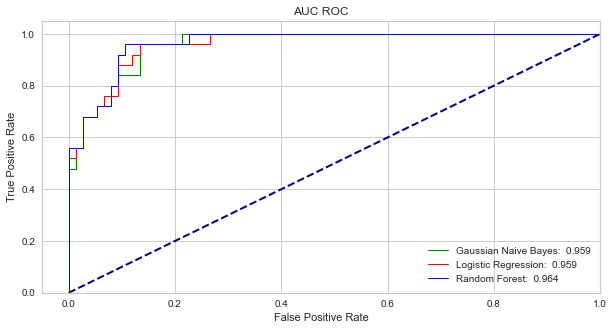

In [166]:
fig = plt.figure(figsize=(10,5))
plt.plot(roc_nb.FPR, roc_nb.TPR, color='green', lw=1, label= "Gaussian Naive Bayes" + ':  %.3f' % metrics_nb.at['ROC AUC', metrics_nb.columns.values.tolist()[0]])
plt.plot(roc_lgrb.FPR, roc_lgrb.TPR, color='red', lw=1, label= "Logistic Regression" + ':  %.3f' % metrics_log.at['ROC AUC', metrics_log.columns.values.tolist()[0]])
plt.plot(roc_rf.FPR, roc_rf.TPR, color='blue', lw=1, label= "Random Forest" + ':  %.3f' % metrics_rf.at['ROC AUC', metrics_rf.columns.values.tolist()[0]])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize='small')
plt.title('AUC ROC')
plt.show()

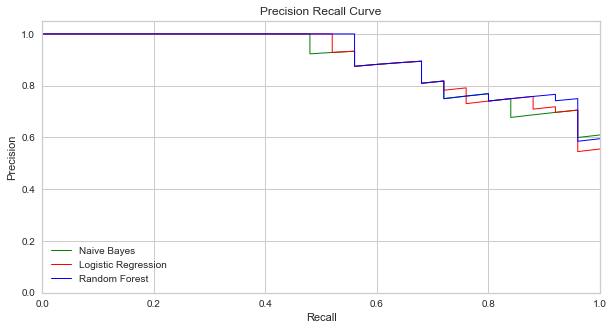

In [175]:
fig = plt.figure(figsize=(10,5))
plt.plot(prc_nb.Recall, prc_nb.Precision, color='green', lw=1, label= metrics_nb.columns.values.tolist()[0])
plt.plot(prc_lgrb.Recall, prc_lgrb.Precision, color='red', lw=1, label= metrics_log.columns.values.tolist()[0])
plt.plot(prc_rf.Recall, prc_rf.Precision, color='blue', lw=1, label= metrics_rf.columns.values.tolist()[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize='small')
plt.title('Precision Recall Curve')
plt.show()

In [167]:
roc_nb.FPR == roc_lgrb.FPR

ValueError: Can only compare identically-labeled Series objects